In [31]:
import sys
import os

# Add src directory to the Python path so imports work
sys.path.append(os.path.abspath(os.path.join("..", "src")))

# 🌤️ Weather Forecasting RL Agent

This notebook demonstrates a Reinforcement Learning (RL) agent that learns to predict or react to temperature changes using Q-learning.  
The environment simulates weather patterns, and the agent learns to minimize prediction errors through exploration and exploitation.

Fetching real weather data for germany...
  Location: Germany (center)
  Coordinates: 51.1657°N, 10.4515°E
  Attempting to fetch from API...
  ⚠ API not accessible: HTTPError
  ℹ Generating realistic German weather simulation instead...
  Location: Germany (center)
  Date range: 2016-01-01 to 2025-12-31
  Generating realistic German weather patterns...
  ✓ Generated 3653 days of realistic temperature data
  Temperature range: -13.1°C to 41.6°C
  Average temperature: 11.4°C (typical for Germany: ~10°C)
✅ Training complete.
✅ Evaluation accuracy on 2025 data: 62.26%


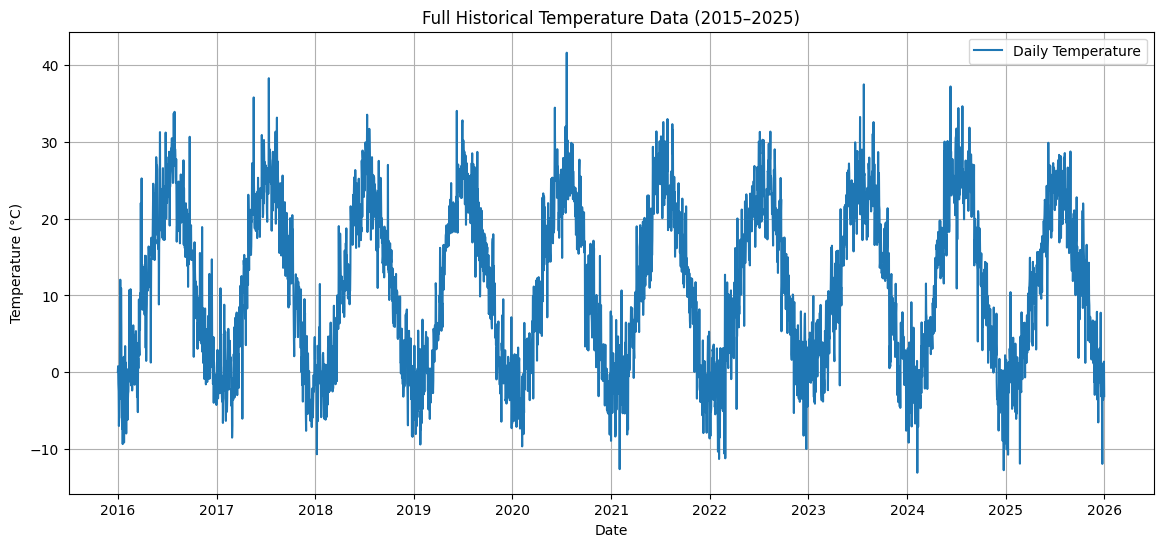

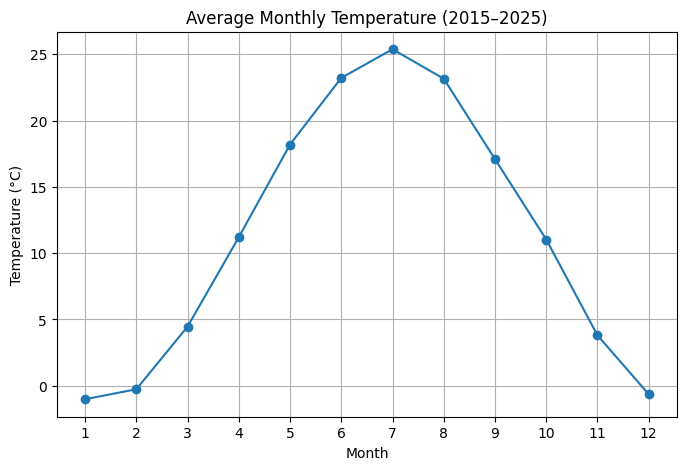

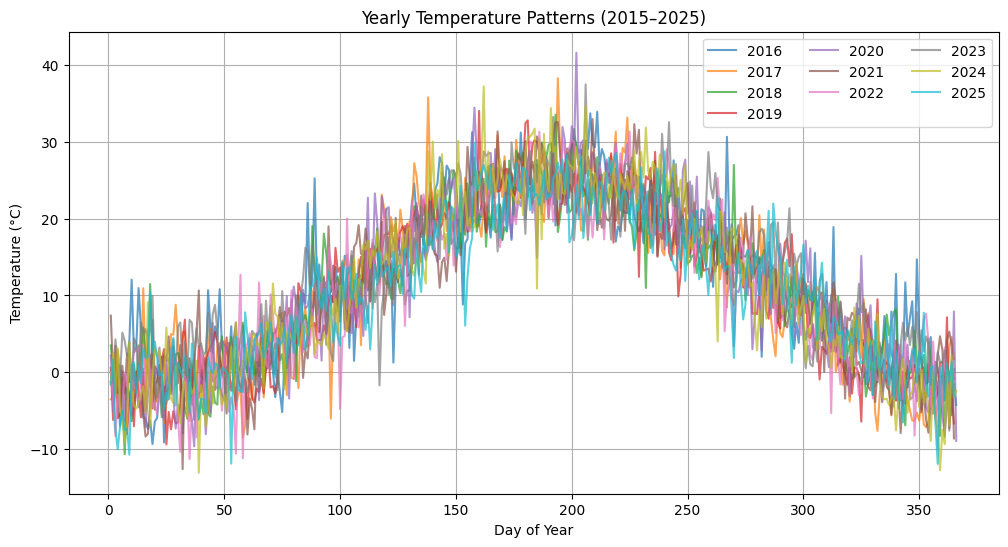

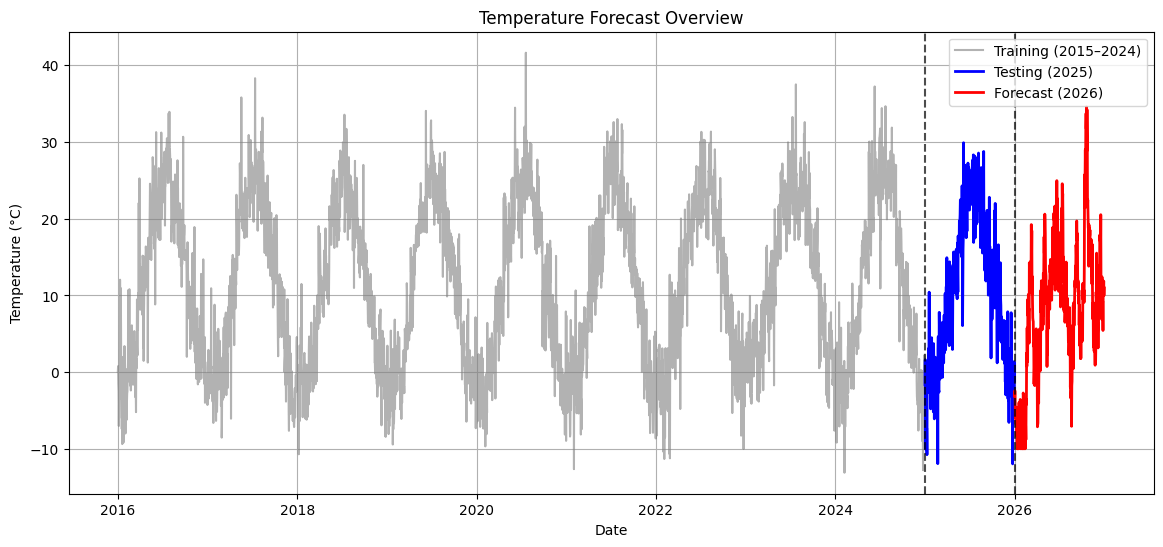

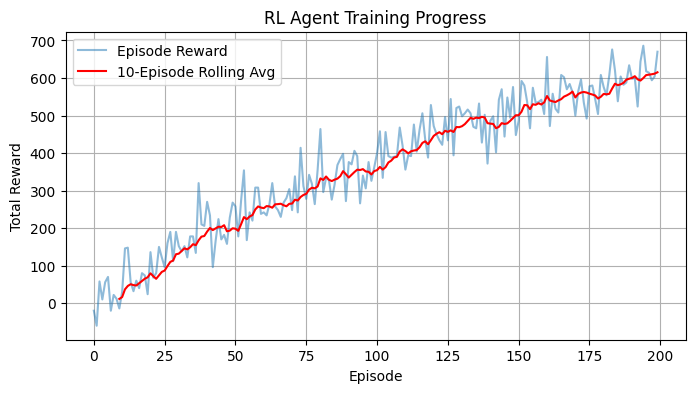

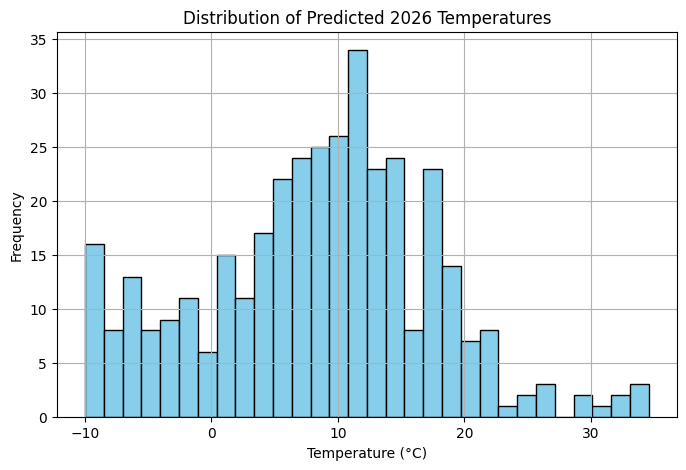

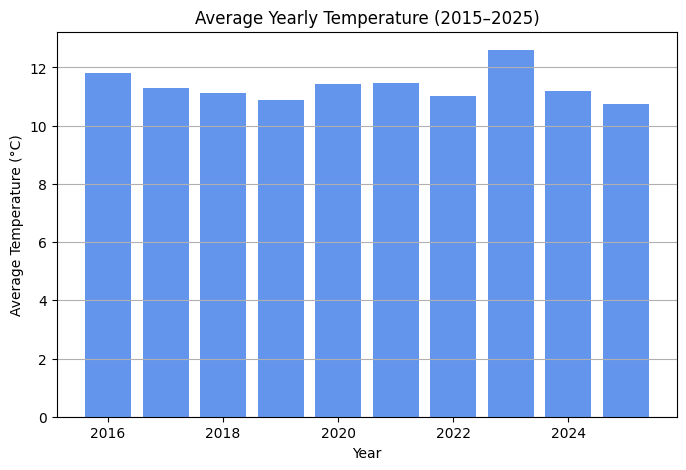

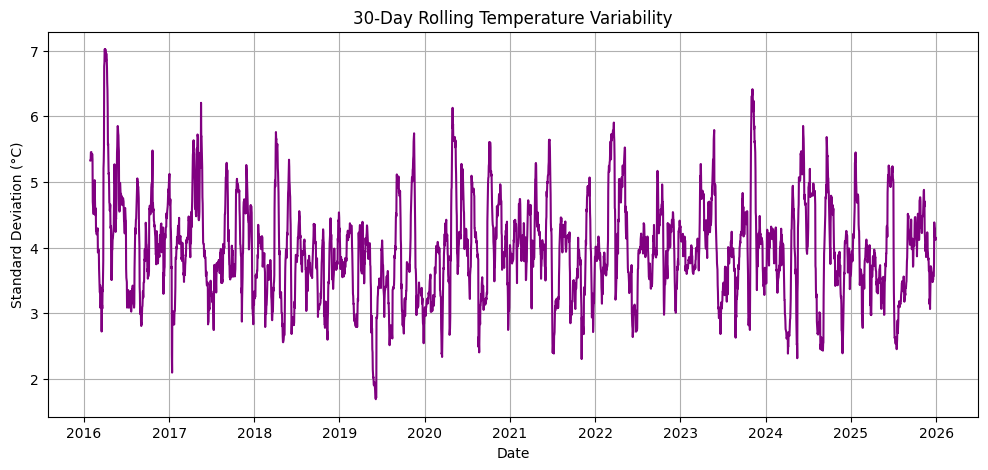

In [42]:
import numpy as np
import pandas as pd
from train import train_agent
import matplotlib.pyplot as plt
from weather_data import WeatherDataGenerator
from rl_agent import WeatherRLAgent

# 1️⃣ Generate 10 years of weather data (2015–2025)
weather_gen = WeatherDataGenerator(use_real_data=True, location="germany")
data = weather_gen.get_data()

# Split into train/test
train_df = data[data['date'].dt.year < 2025]
test_df  = data[data['date'].dt.year == 2025]

train_temps = train_df['temperature'].values
test_temps = test_df['temperature'].values

# 2️⃣ Initialize the RL agent
agent = WeatherRLAgent(
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.01
)

# 3️⃣ Train the agent
episodes = 200
rewards_per_episode = []

for episode in range(episodes):
    total_reward = 0
    for t in range(1, len(train_temps) - 1):
        state = agent.get_state(train_temps, t)
        action = agent.choose_action(state)
        actual_trend = 1 if train_temps[t + 1] > train_temps[t] else 0
        reward = 1 if action == actual_trend else -1
        next_state = agent.get_state(train_temps, t + 1)
        agent.update_q_value(state, action, reward, next_state)
        total_reward += reward
    agent.decay_epsilon()
    rewards_per_episode.append(total_reward)

print("✅ Training complete.")

# 4️⃣ Evaluate performance on 2025 test data
correct = 0
total = 0
predicted_trends = []

for t in range(1, len(test_temps) - 1):
    state = agent.get_state(test_temps, t)
    action = agent.choose_action(state)
    actual_trend = 1 if test_temps[t + 1] > test_temps[t] else 0
    predicted_trends.append(action)
    if action == actual_trend:
        correct += 1
    total += 1

accuracy = correct / total
print(f"✅ Evaluation accuracy on 2025 data: {accuracy:.2%}")

# 5️⃣ Predict temperatures for 2026
mean_temp = np.mean(train_temps)
daily_changes = np.diff(train_temps)
delta_std = np.std(daily_changes)
delta_mean = np.mean(daily_changes)

predicted_temps = [test_temps[-1]]

for _ in range(365):
    state = agent.get_state(predicted_temps, len(predicted_temps) - 1)
    action = agent.choose_action(state)

    delta = abs(np.random.normal(delta_mean, delta_std))
    next_temp = predicted_temps[-1] + (delta if action == 1 else -delta)

    # Mean reversion toward long-term average
    next_temp += 0.05 * (mean_temp - next_temp)

    # Clip to realistic range
    next_temp = np.clip(next_temp, -10, 35)

    predicted_temps.append(next_temp)

# 6. Plot full historical temperature overview
plt.figure(figsize=(14, 6))
plt.plot(data['date'], data['temperature'], color='tab:blue', label='Daily Temperature')
plt.title('Full Historical Temperature Data (2015–2025)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.show()

# 7. Plot average monthly temperature pattern
monthly_avg = data.groupby(data['date'].dt.month)['temperature'].mean()
plt.figure(figsize=(8, 5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.xticks(range(1, 13))
plt.title('Average Monthly Temperature (2015–2025)')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# 8. Plot yearly temperature comparison
plt.figure(figsize=(12, 6))
for year, group in data.groupby(data['date'].dt.year):
    plt.plot(group['date'].dt.dayofyear, group['temperature'], label=str(year), alpha=0.7)

plt.title('Yearly Temperature Patterns (2015–2025)')
plt.xlabel('Day of Year')
plt.ylabel('Temperature (°C)')
plt.legend(ncol=3)
plt.grid(True)
plt.show()

# 9. Plot training vs testing vs predicted periods
plt.figure(figsize=(14, 6))
plt.plot(train_df['date'], train_df['temperature'], label='Training (2015–2024)', color='gray', alpha=0.6)
plt.plot(test_df['date'], test_df['temperature'], label='Testing (2025)', color='blue', linewidth=2)

future_dates = pd.date_range(start='2026-01-01', periods=len(predicted_temps))
plt.plot(future_dates, predicted_temps, label='Forecast (2026)', color='red', linewidth=2)

plt.axvline(pd.Timestamp('2025-01-01'), color='black', linestyle='--', alpha=0.7)
plt.axvline(pd.Timestamp('2026-01-01'), color='black', linestyle='--', alpha=0.7)
plt.title('Temperature Forecast Overview')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# 10. Plot training progress
plt.figure(figsize=(8, 4))
plt.plot(rewards_per_episode, alpha=0.5, label='Episode Reward')
rolling_avg = pd.Series(rewards_per_episode).rolling(10).mean()
plt.plot(rolling_avg, color='red', label='10-Episode Rolling Avg')
plt.title('RL Agent Training Progress')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

# 11. Plot forecast distribution
plt.figure(figsize=(8,5))
plt.hist(predicted_temps, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted 2026 Temperatures')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 12. Plot year-over-year mean comparison
yearly_avg = data.groupby(data['date'].dt.year)['temperature'].mean()
plt.figure(figsize=(8,5))
plt.bar(yearly_avg.index, yearly_avg.values, color='cornflowerblue')
plt.title('Average Yearly Temperature (2015–2025)')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.grid(True, axis='y')
plt.show()

# 13. Plot rolling variability for climatology insight
data['rolling_std'] = data['temperature'].rolling(30).std()
plt.figure(figsize=(12,5))
plt.plot(data['date'], data['rolling_std'], color='purple')
plt.title('30-Day Rolling Temperature Variability')
plt.xlabel('Date')
plt.ylabel('Standard Deviation (°C)')
plt.grid(True)
plt.show()